In [140]:
import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 
import patsy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn import feature_selection


Populating the interactive namespace from numpy and matplotlib


In [141]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [142]:
horror_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie               684 non-null    object 
 1   Year                684 non-null    int64  
 2   Runtime_min         684 non-null    int64  
 3   Genres              684 non-null    object 
 4   IMDB_Score          684 non-null    float64
 5   IMDB_Votes          684 non-null    int64  
 6   Metascore           684 non-null    int64  
 7   Director            684 non-null    object 
 8   Star                684 non-null    object 
 9   Budget              684 non-null    int64  
 10  Country             684 non-null    object 
 11  Novel_Adaptation    684 non-null    int64  
 12  Male_Score          684 non-null    float64
 13  Male_Total_Votes    684 non-null    int64  
 14  Female_Score        684 non-null    float64
 15  Female_Total_Votes  684 non-null    int64  
 16  Link_stu

In [143]:
horror_df['Genres']=horror_df['Genres'].apply(lambda x: [y.strip()for y in x])


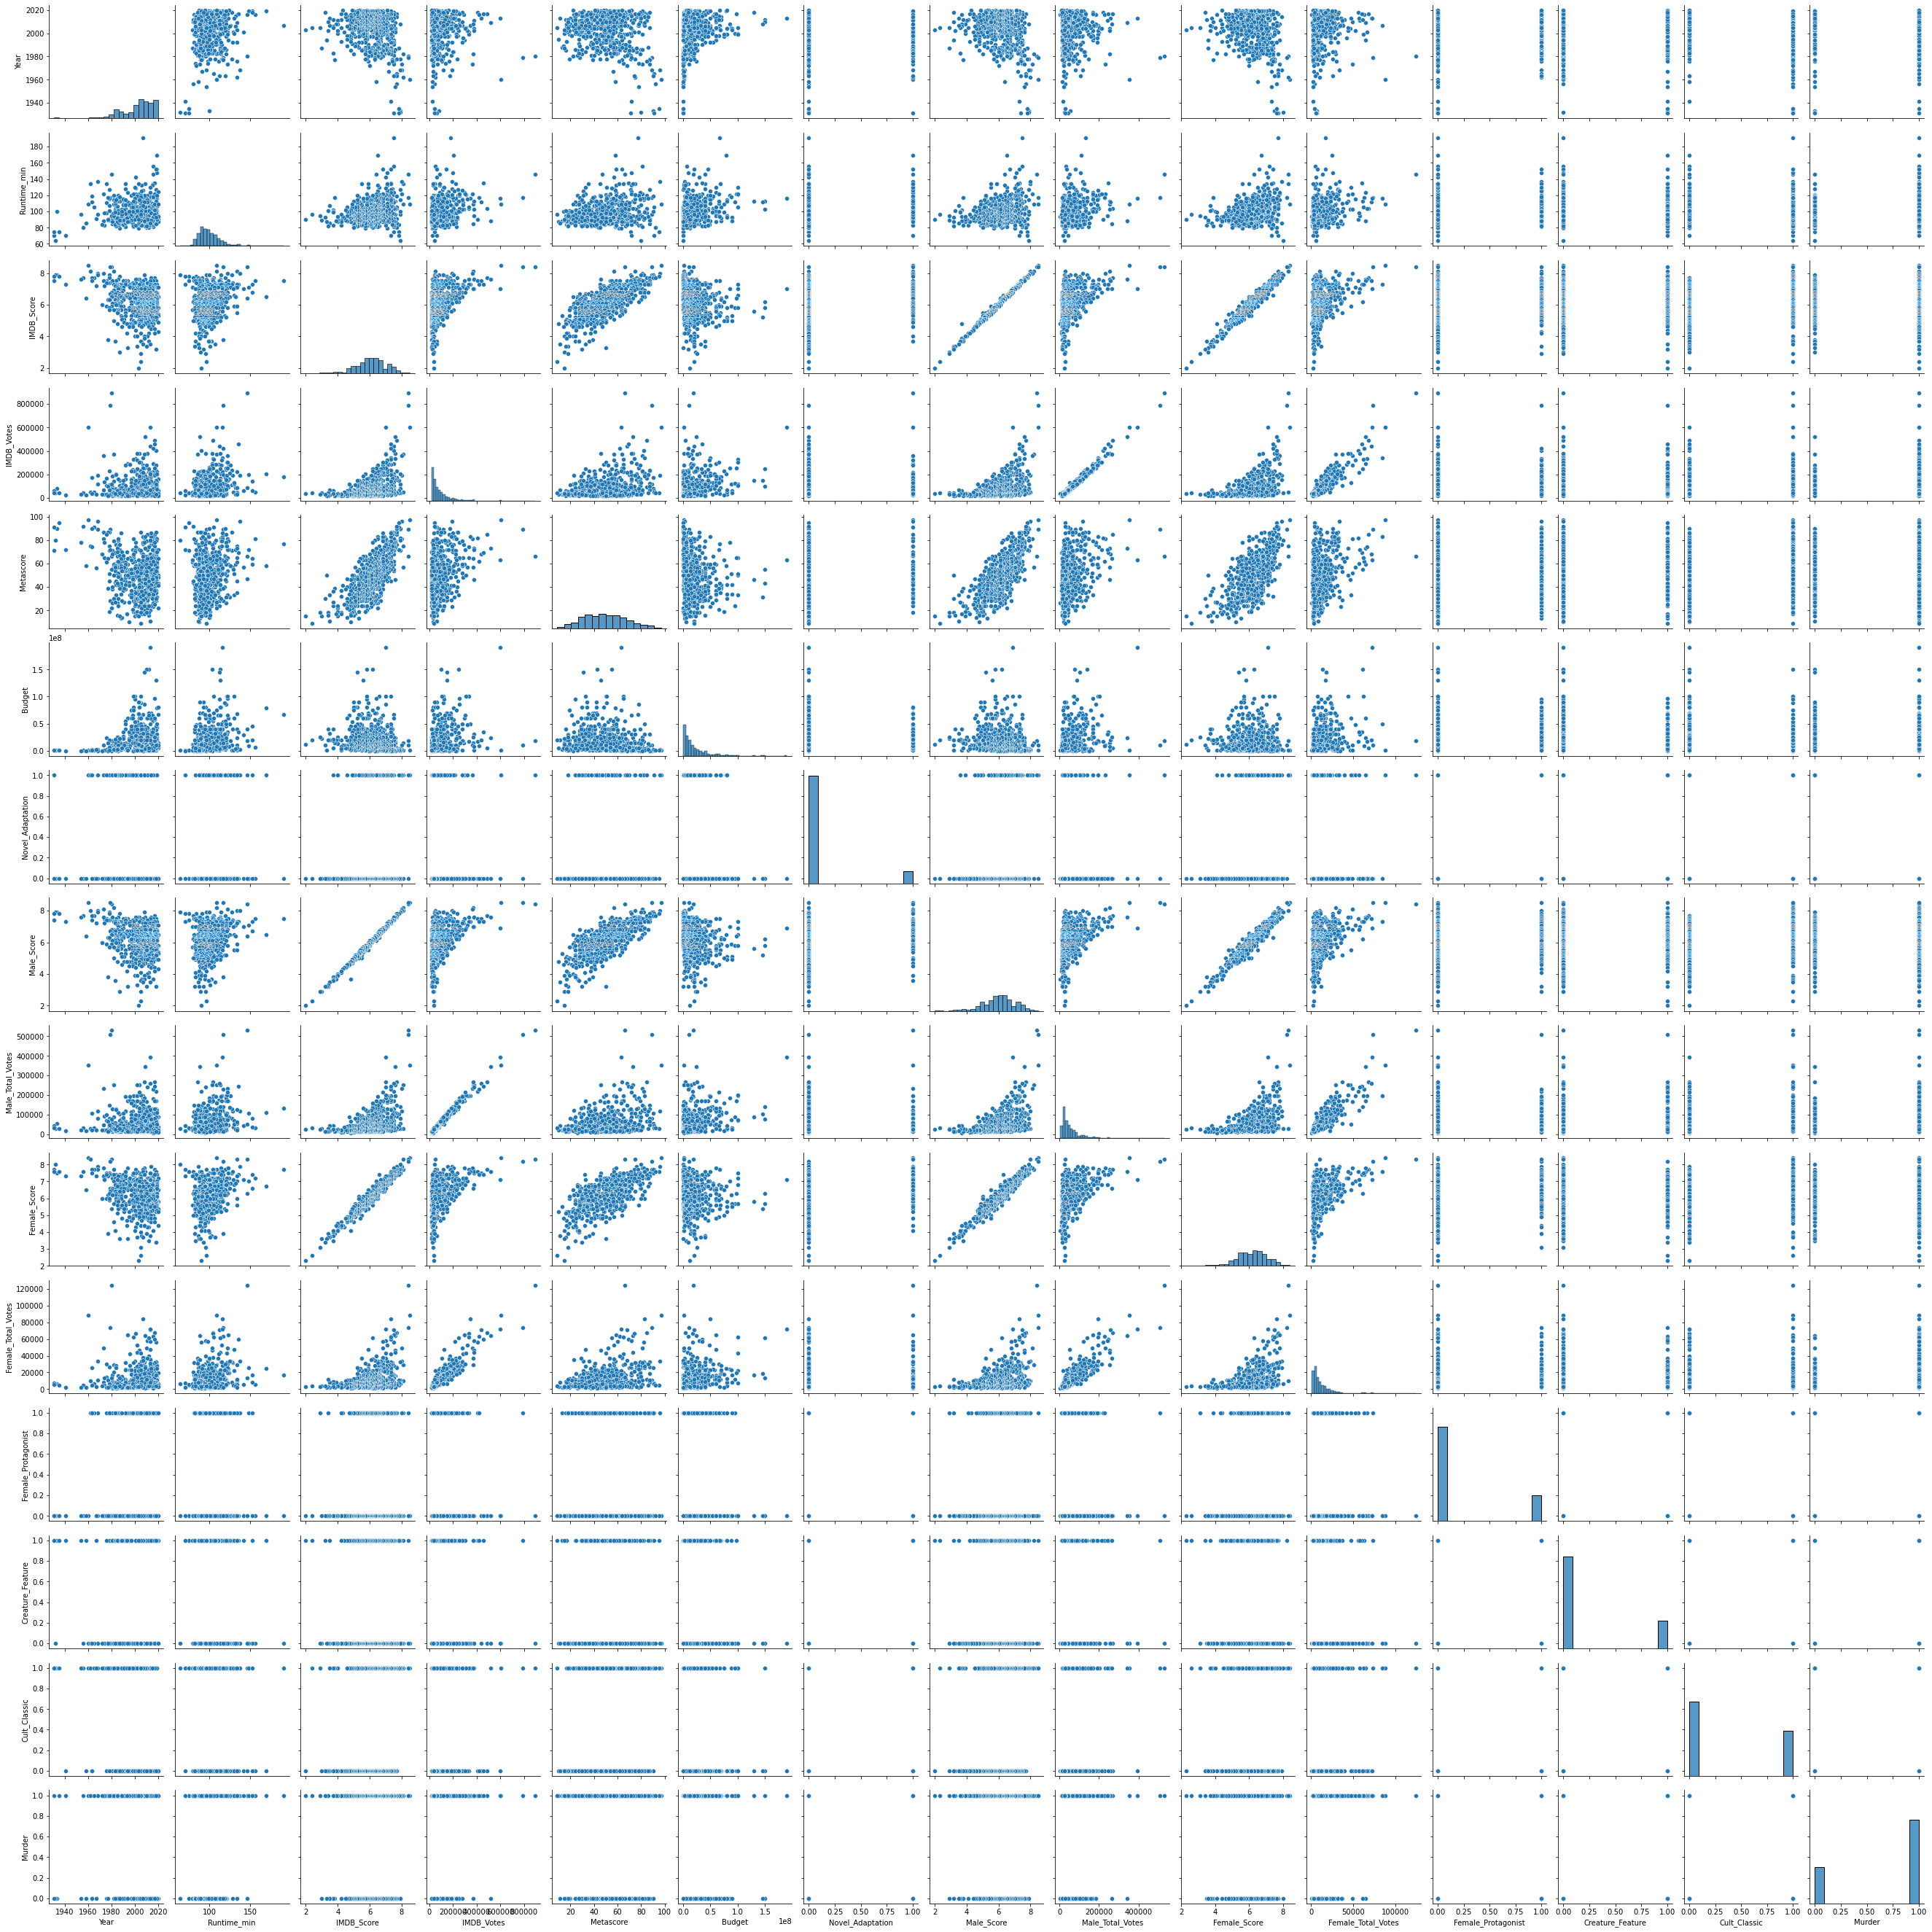

In [5]:
sns.pairplot(horror_df)

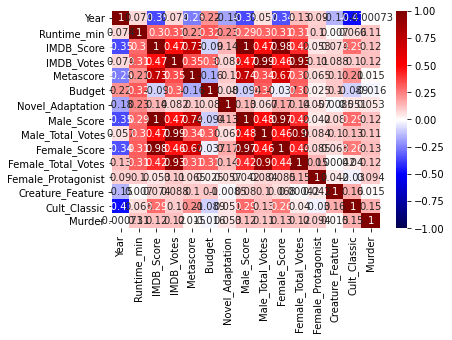

In [144]:
horror_df.corr()
sns.heatmap(horror_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [145]:
X=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget','Metascore']]
y=horror_df['Female_Score']

In [ ]:
#Need to convert Genres and Director into dummies
#pipeline to test different alpha values for ridge and or lasso, standardscaler,
#and categorical conversion

In [146]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,X],axis=1)
X=combined_X
y=horror_df['Female_Score']

In [147]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [148]:
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     23.92
Date:                Tue, 19 Jan 2021   Prob (F-statistic):           8.43e-62
Time:                        22:26:31   Log-Likelihood:                -359.25
No. Observations:                 410   AIC:                             768.5
Df Residuals:                     385   BIC:                             868.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 29.2580      4.843      6.041      0.000      19.736      38.780
Action                 0.1347      0.103      1.301      0.194      -0.069       0.338
Adventure             -0.2704      0.132     -2.050      0.041      -0.530      -0.011
Animation            1.13e-12   1.08e-11      0.105      0.917   -2.01e-11    2.24e-11
Biography             -0.2579      0.458     -0.563      0.574      -1.158       0.642
Comedy                -0.1482      0.101     -1.468      0.143      -0.347       0.050
Crime                  0.3005      0.125      2.397      0.017       0.054       0.547
Drama                 -0.0063      0.089     -0.072      0.943      -0.180       0.168
Family                -0.0147      0.311     -0.047      0.962      -0.627       0.598
Fantasy                0.0987      0.094      1.049      0.295      -0.086       0.284
History            -5.619e-15    5.5e-14     -0.102      0.919   -1.14e-13    1.03e-13
Horror                -0.2228      0.161     -1.386      0.166      -0.539       0.093
Music                 -0.1456      0.610     -0.239      0.812      -1.346       1.054
Musical             2.728e-15   2.57e-14      0.106      0.916   -4.79e-14    5.33e-14
Mystery               -0.0233      0.081     -0.286      0.775      -0.183       0.137
Romance               -0.0889      0.360     -0.247      0.805      -0.797       0.619
Sci-Fi                -0.2112      0.101     -2.101      0.036      -0.409      -0.014
Thriller              -0.0530      0.088     -0.601      0.548      -0.226       0.120
Western               -0.0862      0.615     -0.140      0.889      -1.295       1.123
Year                  -0.0128      0.002     -5.269      0.000      -0.018      -0.008
Runtime_min            0.0111      0.003      4.422      0.000       0.006       0.016
Novel_Adaptation       0.0842      0.103      0.819      0.413      -0.118       0.286
Female_Protagonist     0.0575      0.079      0.724      0.470      -0.099       0.214
Creature_Feature      -0.1164      0.082     -1.427      0.154      -0.277       0.044
Cult_Classic           0.0903      0.076      1.189      0.235      -0.059       0.239
Murder                 0.1461      0.067      2.178      0.030       0.014       0.278
Budget              1.594e-09   1.48e-09      1.080      0.281   -1.31e-09     4.5e-09
Metascore              0.0303      0.002     15.718      0.000       0.027       0.034
==============================================================================
Omnibus:                       26.860   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.346
Skew:                          -0.527   Prob(JB):                     2.11e-08
Kurtosis:                       3.978   Cond. No.                     

In [149]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
X['Director']=horror_df['Director'].replace(other_d,'Other')
X=pd.get_dummies(X)
y=horror_df['Female_Score']

In [150]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [151]:
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     13.95
Date:                Tue, 19 Jan 2021   Prob (F-statistic):           7.93e-55
Time:                        22:26:36   Log-Likelihood:                -344.16
No. Observations:                 410   AIC:                             778.3
Df Residuals:                     365   BIC:                             959.1
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           27.6649      4.725      5.855      0.000      18.374      36.956
Action                           0.1243      0.105      1.180      0.239      -0.083       0.331
Adventure                       -0.2867      0.132     -2.169      0.031      -0.547      -0.027
Animation                    -2.784e-12   4.77e-13     -5.837      0.000   -3.72e-12   -1.85e-12
Biography                       -0.2758      0.455     -0.607      0.544      -1.170       0.618
Comedy                          -0.1717      0.104     -1.647      0.100      -0.377       0.033
Crime                            0.2604      0.128      2.040      0.042       0.009       0.511
Drama                           -0.0176      0.090     -0.196      0.844      -0.194       0.159
Family                          -0.0122      0.310     -0.039      0.969      -0.622       0.598
Fantasy                          0.0827      0.095      0.867      0.386      -0.105       0.270
History                      -2.778e-15   6.92e-16     -4.013      0.000   -4.14e-15   -1.42e-15
Horror                          -0.2312      0.161     -1.434      0.153      -0.548       0.086
Music                           -0.1846      0.637     -0.290      0.772      -1.437       1.068
Musical                      -5.516e-15   1.03e-15     -5.341      0.000   -7.55e-15   -3.49e-15
Mystery                         -0.0766      0.084     -0.915      0.361      -0.241       0.088
Romance                         -0.1037      0.357     -0.290      0.772      -0.806       0.599
Sci-Fi                          -0.2318      0.103     -2.249      0.025      -0.435      -0.029
Thriller                        -0.1073      0.091     -1.176      0.240      -0.287       0.072
Western                         -0.1102      0.610     -0.181      0.857      -1.310       1.089
Year                            -0.0127      0.002     -5.093      0.000      -0.018      -0.008
Runtime_min                      0.0112      0.003      4.391      0.000       0.006       0.016
Novel_Adaptation                 0.0857      0.104      0.825      0.410      -0.119       0.290
Female_Protagonist               0.0696      0.082      0.849      0.397      -0.092       0.231
Creature_Feature                -0.1024      0.083     -1.229      0.220      -0.266       0.061
Cult_Classic                     0.1246      0.077      1.622      0.106      -0.026       0.276
Murder                           0.1382      0.068      2.036      0.042       0.005       0.272
Budget                        1.108e-09    1.6e-09      0.693      0.489   -2.03e-09    4.25e-09
Metascore                        0.0301      0.002     15.083      0.000       0.026       0.034
Director_                        1.3617      0.299      4.553      0.000    

In [152]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.44273627931138804

In [15]:
alpha_list=np.logspace(-10,1,100)
#create pipeline using gridsearch cv

In [153]:
X=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget','Metascore']]
y=horror_df['Female_Score']

In [154]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,X],axis=1)
X=combined_X
y=horror_df['Female_Score']

In [155]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
X['Director']=horror_df['Director'].replace(other_d,'Other')
X=pd.get_dummies(X)
y=horror_df['Female_Score']

In [156]:
X.shape

(684, 49)

In [157]:
X.Metascore

0      97
1      66
2      89
3      57
4      75
       ..
679    30
680    15
681    18
682     9
683    15
Name: Metascore, Length: 684, dtype: int64

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)

In [20]:
std=StandardScaler()
std.fit(X_train)

StandardScaler()

In [21]:
X_tr=std.transform(X_train)
X_te=std.transform(X_test)

In [69]:
alpha_list=np.logspace(-10,10,100)
ridge_model=RidgeCV(alphas=alpha_list,cv=5)
ridge_model.fit(X_tr,y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
       2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07,
       1.70735265e-07, 2.71858824e-07, 4.32876128e-07, 6.89261210e-07,
       1.09749877e-06, 1.74752840e-0...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10]),
        cv=5)

In [70]:
ridge_model.alpha_

52.14008287999674

In [46]:
list(zip(X_train.columns, ridge_model.coef_))

[('Action', 0.023253836530284736),
 ('Adventure', -0.07773607967803825),
 ('Animation', 0.0329660332417416),
 ('Biography', -0.021452082509816818),
 ('Comedy', -0.016811135777091594),
 ('Crime', 0.037426532253995705),
 ('Drama', -0.004141237984529574),
 ('Family', 0.0020812750047880762),
 ('Fantasy', 0.01720141321616466),
 ('History', -0.006677994670197426),
 ('Horror', -0.07302226310980396),
 ('Music', 0.0),
 ('Musical', 0.03800858968217725),
 ('Mystery', -0.027955802320127843),
 ('Romance', 0.03446450340655516),
 ('Sci-Fi', -0.019093715976500093),
 ('Thriller', -0.040328133381583725),
 ('Western', 0.0),
 ('Year', -0.1916240491707054),
 ('Runtime_min', 0.17176752568625125),
 ('Novel_Adaptation', 0.01612870069504055),
 ('Female_Protagonist', 0.01668646704264254),
 ('Creature_Feature', -0.029202890244223075),
 ('Cult_Classic', 0.039665206843866166),
 ('Murder', 0.05365645757732844),
 ('Budget', 0.007141673183665072),
 ('Metascore', 0.4822011686671838),
 ('Director_', -0.0030467921540674

In [47]:
test_set_pred = ridge_model.predict(X_te)

In [48]:
r2_score(y_test,test_set_pred)

0.4531655210001575

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)

In [159]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('poly',PolynomialFeatures()),
    ('ss',StandardScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
poly_pred=pipe.predict(X_test)

In [160]:
r2_score(y_test,poly_pred)

0.4014665965296895

In [161]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('ss',StandardScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
pred=pipe.predict(X_test)

In [162]:
r2_score(y_test,pred)

0.4623236285989939

In [163]:
pipe.named_steps

{'ss': StandardScaler(),
 'search': GridSearchCV(cv=5, estimator=Ridge(),
              param_grid={'alpha': array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
        6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
        4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
        2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07,
        1.70735265e-07, 2.71858824e-07, 4.32876128e-07, 6....
        2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
        1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
        9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
        5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
        3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
        2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10]),
                          'fit_intercept': [True, False]})}

In [164]:
pipe.named_steps['search'].best_params_


{'alpha': 52.14008287999674, 'fit_intercept': True}

In [165]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [166]:
r2_score(y_test,robust_pred)

0.4786256192605399

In [167]:
alpha_list=np.logspace(-10,10,100)
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(),
                          param_grid=params_Lasso,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
lasso_pred=pipe.predict(X_test)

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.142637518784994, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.168248566640685, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557062266405808, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.142638202984372, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.168249452825904, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557066262934427, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.142641592468067, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.168252621316157, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557076794246854, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.142655055031653, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.168265132793337, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557119323084692, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.14270909739598, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.168315621886492, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557291569405436, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5557986790309855, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.088831559543337, tolerance: 0.03762880593607306
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.2014624114277, tolerance: 1.6691259999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.2091412513901, tolerance: 1.6691259999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.82709004600736, tolerance: 1.6765949999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.17701507039908, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.24949883802412, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.8322178723074, tolerance: 1.6712110000000002
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.35863896910365, tolerance: 1.6691259999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

In [168]:
r2_score(y_test,lasso_pred)

0.48069732027445267

In [169]:
lasso_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
lasso_coef

[('Action', 0.11079891813285075),
 ('Adventure', -0.1276609645134851),
 ('Animation', 0.03721077591135455),
 ('Biography', -0.0),
 ('Comedy', -0.014552522976146861),
 ('Crime', 0.21015112856235166),
 ('Drama', 0.009582727520756375),
 ('Family', 0.0),
 ('Fantasy', 0.05571012797179478),
 ('History', 0.0),
 ('Horror', -0.08615990759896676),
 ('Music', -0.0),
 ('Musical', 0.2770000934179158),
 ('Mystery', -0.07477117161207356),
 ('Romance', -0.0),
 ('Sci-Fi', -0.08285603660394546),
 ('Thriller', -0.06064735703629243),
 ('Western', -0.0),
 ('Year', -0.27534519639705946),
 ('Runtime_min', 0.17516619420243607),
 ('Novel_Adaptation', 0.04353870073502985),
 ('Female_Protagonist', 0.11823408992006991),
 ('Creature_Feature', -0.047507037817110194),
 ('Cult_Classic', 0.06162210612019716),
 ('Murder', 0.1957416130322372),
 ('Budget', 0.013242623305387414),
 ('Metascore', 0.7878685225811243),
 ('Director_', -0.10036646498153645),
 ('Director_Alexandre Aja', -0.1465470887122365),
 ('Director_Christop

In [170]:
filtered=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Drama', 0.009582727520756375),
 ('Budget', 0.013242623305387414),
 ('Director_John Carpenter', 0.014252599818469186),
 ('Comedy', -0.014552522976146861),
 ('Director_Other', -0.033700690544308194),
 ('Animation', 0.03721077591135455),
 ('Novel_Adaptation', 0.04353870073502985),
 ('Creature_Feature', -0.047507037817110194),
 ('Fantasy', 0.05571012797179478),
 ('Thriller', -0.06064735703629243),
 ('Cult_Classic', 0.06162210612019716),
 ('Mystery', -0.07477117161207356),
 ('Sci-Fi', -0.08285603660394546),
 ('Horror', -0.08615990759896676),
 ('Director_', -0.10036646498153645),
 ('Director_Joe Dante', -0.10194086800343848),
 ('Action', 0.11079891813285075),
 ('Female_Protagonist', 0.11823408992006991),
 ('Director_Eli Roth', -0.12616255236914029),
 ('Adventure', -0.1276609645134851),
 ('Director_Alexandre Aja', -0.1465470887122365),
 ('Runtime_min', 0.17516619420243607),
 ('Murder', 0.1957416130322372),
 ('Crime', 0.21015112856235166),
 ('Director_Christopher Landon', 0.2475619330563220

In [171]:
X1=X.drop(columns='Metascore')
X1

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,...,Director_Mike Flanagan,Director_Other,Director_Paul W.S. Anderson,Director_Rob Zombie,Director_Sam Raimi,Director_Steve Miner,Director_Tim Burton,Director_Tobe Hooper,Director_Wes Craven,Director_William Brent Bell
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
680,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
681,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
682,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [172]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2,random_state=41)

In [180]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X1_train,y_train)
robust_pred_bad=pipe.predict(X1_test)

In [181]:
r2_score(y_test,robust_pred_bad)
#0.16952020332458073 with robust without poly
#-0.9371092424488339 with roboust scaling after poly
#0.1512751582215145 with robust scaling before poly
#0.17795988740107826 with standard scalar before poly (ill conditioned matrix)
#0.20877948373730093 with standard scalar after poly (causes mapping issue)
#0.24325429577470314 with ss and no poly

0.25415879795827956

In [175]:
 len(pipe.named_steps['search'].best_estimator_.coef_)

48

In [176]:
ridge_coef=list(zip(X1_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Comedy', -0.0010837919536017969),
 ('Romance', 0.0022510696591015456),
 ('Fantasy', -0.0026164301304336343),
 ('Director_Greg McLean', -0.004489378469590623),
 ('Director_Joe Dante', -0.005558743417041167),
 ('Director_Tobe Hooper', -0.007545098838586828),
 ('Mystery', -0.007863927171692198),
 ('Action', 0.008330017084248034),
 ('Director_', -0.008773864688272856),
 ('Director_Alexandre Aja', -0.010205733836924864),
 ('Family', -0.01103876554826295),
 ('Director_Steve Miner', -0.011537890579379451),
 ('Western', 0.013518213596727365),
 ('Director_Darren Lynn Bousman', 0.014256839665699541),
 ('Director_Rob Zombie', -0.014614747669972691),
 ('Director_John Carpenter', 0.014775016738325857),
 ('Director_George A. Romero', -0.014923521249171066),
 ('Creature_Feature', 0.016885734573652392),
 ('Director_Paul W.S. Anderson', 0.01880201341124331),
 ('Biography', -0.018903648512315428),
 ('Sci-Fi', 0.01971618820213728),
 ('Director_Eli Roth', -0.030911918347005112),
 ('Music', 0.0309645684

In [179]:
alpha_list=np.logspace(-10,10,100)
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
    
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(),
                          param_grid=params_Lasso,
                          cv=5,
                          refit=True))
])
pipe.fit(X1_train,y_train)
robust_pred_bad_l=pipe.predict(X1_test)

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.52460196947483, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.777186194909632, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4843360185591905, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.3132905927788, tolerance: 1.6712110000000002
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.524603757263776, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.777185850232044, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.336788366103, tolerance: 1.6765949999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.4929389635131, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.43327786808084, tolerance: 1.6699559999999996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.4930083955858, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.43331712030658, tolerance: 1.6699559999999996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.31336364752735, tolerance: 1.6712110000000002
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.687057686823437, tolerance: 0.03762880593607306
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.906624961899, tolerance: 1.6691259999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.3371467008981, tolerance: 1.6765949999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.10816066265653, tolerance: 0.03576304109589041
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.687196690157009, tolerance: 0.03762880593607306
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.90795966571955, tolerance: 1.6691259999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.52577554768847, tolerance: 0.03730994508009154
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.63888350399472, tolerance: 0.03609013729977117
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.48471549624702, tolerance: 0.03477111415525115
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.5082212976328, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.44164757014482, tolerance: 1.6699559999999996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.32600571284706, tolerance: 1.6712110000000002
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.20364285972744, tolerance: 1.6765949999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.47648491002406, tolerance: 1.692996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.46704277841673, tolerance: 1.6699559999999996
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

KeyboardInterrupt: 

In [128]:
r2_score(y_test,robust_pred_bad_l)
#0.1485972753425322  with robust without poly
#-0.00035148328457279554 with robust and poly
#0.1835335363782994 with standard scalar after poly

0.1835335363782994

In [120]:
lasso_coef=list(zip(X1_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
lasso_coef
filtered=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Fantasy', -0.014871697407523653),
 ('Novel_Adaptation', 0.017198075036058056),
 ('Creature_Feature', -0.020137055083609332),
 ('Mystery', 0.031711638337655085),
 ('Director_Tobe Hooper', -0.03383270821691524),
 ('Action', -0.034843989185237186),
 ('Comedy', 0.045553940543425354),
 ('Director_John Carpenter', 0.047154804443862754),
 ('Thriller', -0.0654269247981673),
 ('Budget', -0.083803142957444),
 ('Director_Alexandre Aja', -0.10708507766933749),
 ('Cult_Classic', 0.11608987112283574),
 ('Murder', 0.12672521747250587),
 ('Director_', -0.1269667995192703),
 ('Director_Other', -0.12712965752514785),
 ('Sci-Fi', 0.13012160515609797),
 ('Crime', 0.1499664582701773),
 ('Female_Protagonist', 0.16868356770869536),
 ('Drama', 0.18736009037812204),
 ('Director_Darren Lynn Bousman', 0.22478009186376266),
 ('Director_Steve Miner', -0.22978896976105778),
 ('Director_David Cronenberg', 0.23471070901778815),
 ('Director_Wes Craven', -0.2611224816571623),
 ('Adventure', -0.26826132676459835),
 (